In [23]:
import dill
from sklearn import *
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import common_functions as cf
import importlib
importlib.reload(cf)

SENSOR_LAG = 25 # ms
ARRAY_W = 2
ARRAY_H = 2
NR_SUBREGIONS = 3
ARRAY_SIZE = ARRAY_W * ARRAY_H
ARRAY_SIZE_SUB = (ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)) * (ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1))
NAME_PREFIX = lambda i: f"H1_5-s{i}-20231218-005"
MODEL_NAME_Z = "table_calibration/2x2_grid_subsampling_x3_08032024_schroef2"
MODEL_NAME_XY = "table_calibration/2x2_grid_xy_subsampling_x3_08032024_schroef2"

DATA_NAME = "table_calibration/2x2_grid_subsampling_x3_08032024_schroef2"

# Load the models
z_taxel_models = dill.load(open(os.path.join(os.getcwd(), f'../models/PolyLinear-Deg4/{MODEL_NAME_Z}'), 'rb'))
xy_taxel_models = dill.load(open(os.path.join(os.getcwd(), f'../models/PolyLinear-Deg4/{MODEL_NAME_XY}'), 'rb'))

print(z_taxel_models)
print(xy_taxel_models)

[Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, include_bias=False)),
                ('ridge', Ridge(alpha=1))]), Pipeline(steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=4, in

In [24]:
# Load sensor data file including silicone
TFdata = cf.read_csv_file(f"../data/raw/TF/{DATA_NAME}.csv") 
sensordata = cf.read_csv_file(f'../data/raw/sensor/{DATA_NAME}.csv')

data_columns = [f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)] + [f'Z{i}' for i in range(ARRAY_SIZE)]

# Unwrap sensor data
sensordata = cf.unwrap_data(sensordata, data_columns)

# Time sync
data = cf.time_sync_data(sensordata, TFdata, SENSOR_LAG / 1000)

# Remove mean of first 100 samples
data = cf.offset_data(data, data_columns, 100)

# Remove rows containing NaN values
data = data.dropna()

# Remove other columns
data = data.drop(columns=['t_robot', 'R_x', 'R_y', 'R_z'])

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59476 entries, 1 to 59476
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   59476 non-null  int64  
 1   t_wall  59476 non-null  float64
 2   X0      59476 non-null  float64
 3   Y0      59476 non-null  float64
 4   Z0      59476 non-null  float64
 5   X1      59476 non-null  float64
 6   Y1      59476 non-null  float64
 7   Z1      59476 non-null  float64
 8   X2      59476 non-null  float64
 9   Y2      59476 non-null  float64
 10  Z2      59476 non-null  float64
 11  X3      59476 non-null  float64
 12  Y3      59476 non-null  float64
 13  Z3      59476 non-null  float64
 14  F_x     59476 non-null  float64
 15  F_y     59476 non-null  float64
 16  F_z     59476 non-null  float64
 17  T_x     59476 non-null  float64
 18  T_y     59476 non-null  float64
 19  T_z     59476 non-null  float64
 20  X       59476 non-null  float64
 21  Y       59476 non-null  float64
 22

In [25]:
# Predict forces
points = np.array([[0.33728042, 0.05773226],
 [0.33944982, 0.05771756],
 [0.34161673, 0.05770034],
 [0.34378087, 0.05768131],
 [0.33726447, 0.05556711],
 [0.33943219, 0.0555493 ],
 [0.34159989, 0.0555349 ],
 [0.34376498, 0.05551504],
 [0.33724925, 0.05340412],
 [0.33941416, 0.05338495],
 [0.34158036, 0.05336572],
 [0.34374801, 0.0533503 ],
 [0.33723094, 0.0512359 ],
 [0.33939674, 0.05121703],
 [0.34156259, 0.05119911],
 [0.34372775, 0.05118098]])

for k in range(ARRAY_SIZE_SUB):
  
  x, y = points[k]
  print(x,y)
    
  # Predict
  X_xy = data[[f'X{i}' for i in range(ARRAY_SIZE)] + [f'Y{i}' for i in range(ARRAY_SIZE)]]
  X_z = data[[f'Z{i}' for i in range(ARRAY_SIZE)] + ['X', 'Y']].to_numpy()
  print(X_z.shape)
  X_z[:, 4] = x
  X_z[:, 5] = y
  
  Y_xy = xy_taxel_models[k].predict(X_xy.to_numpy())
  Y_z = z_taxel_models[k].predict(X_z)
  
  # add to PD
  data[f'F_x{k}'] = Y_xy[:, 0]
  data[f'F_y{k}'] = Y_xy[:, 1]
  data[f'F_z{k}'] = np.clip(Y_z[:, 0], 0, 20)

0.33728042 0.05773226
(59476, 6)


0.33944982 0.05771756
(59476, 6)
0.34161673 0.05770034
(59476, 6)
0.34378087 0.05768131
(59476, 6)
0.33726447 0.05556711
(59476, 6)
0.33943219 0.0555493
(59476, 6)
0.34159989 0.0555349
(59476, 6)
0.34376498 0.05551504
(59476, 6)
0.33724925 0.05340412
(59476, 6)
0.33941416 0.05338495
(59476, 6)
0.34158036 0.05336572
(59476, 6)
0.34374801 0.0533503
(59476, 6)
0.33723094 0.0512359
(59476, 6)
0.33939674 0.05121703
(59476, 6)
0.34156259 0.05119911
(59476, 6)
0.34372775 0.05118098
(59476, 6)


In [19]:
# Now make an animation for this
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import matplotlib.animation as animation

points = []

ARRAY_SUB_W = ARRAY_W + (ARRAY_W - 1) * (NR_SUBREGIONS - 1)
ARRAY_SUB_H = ARRAY_H + (ARRAY_H - 1) * (NR_SUBREGIONS - 1)

for i in range(ARRAY_SUB_W):
  for j in range(ARRAY_SUB_H):
    points.append([i, j])

points = np.array(points)

nr_of_frames = len(data['F_z']) // 100

def animate(t):
  
    index = len(data['F_z']) // nr_of_frames * t
  
    print(f"Frame {t} / {nr_of_frames} (index {index})")
  
    # Clear
    plt.cla()
    
    # Plot boundaries of the subregions
    for i in range(ARRAY_SUB_W - 1):
      plt.plot([i + 0.5, i + 0.5], [-0.5, ARRAY_SUB_H - 0.5], 'k')
    for i in range(ARRAY_SUB_H - 1):
      plt.plot([-0.5, ARRAY_SUB_W - 0.5], [i + 0.5, i + 0.5], 'k')

    # Plot the "vector field"
    plt.quiver(points[:, 0], points[:, 1], data.iloc[index][[f'F_x{i}' for i in range(ARRAY_SIZE_SUB)]], data.iloc[index][[f'F_y{i}' for i in range(ARRAY_SIZE_SUB)]])

    # Set aspect ratio
    plt.gca().set_aspect('equal', adjustable='box')

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

matplotlib.animation.FuncAnimation(fig, animate, frames=nr_of_frames)

NameError: name 'matplotlib' is not defined

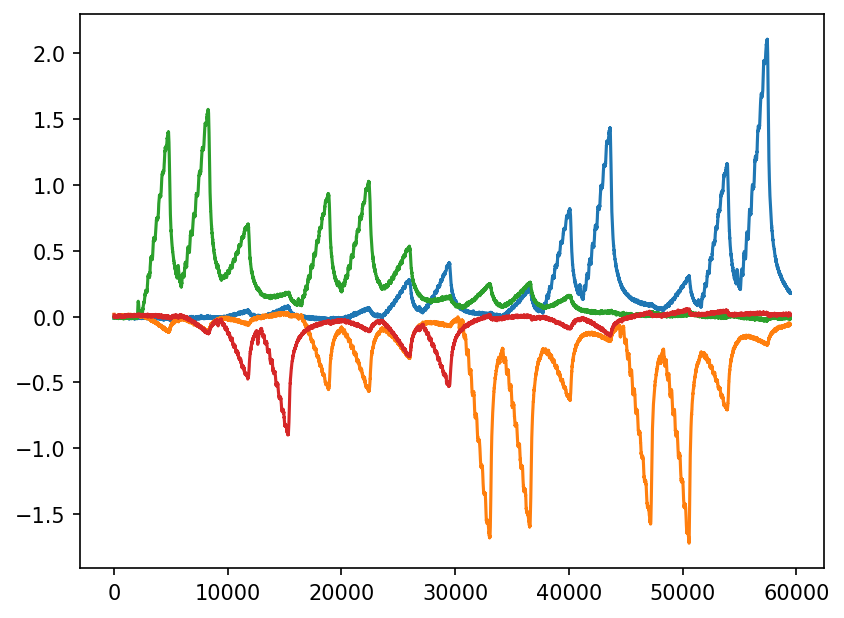

In [26]:
plt.plot(data['Z0'])
plt.plot(data['Z1'])
plt.plot(data['Z2'])
plt.plot(data['Z3'])
plt.show()

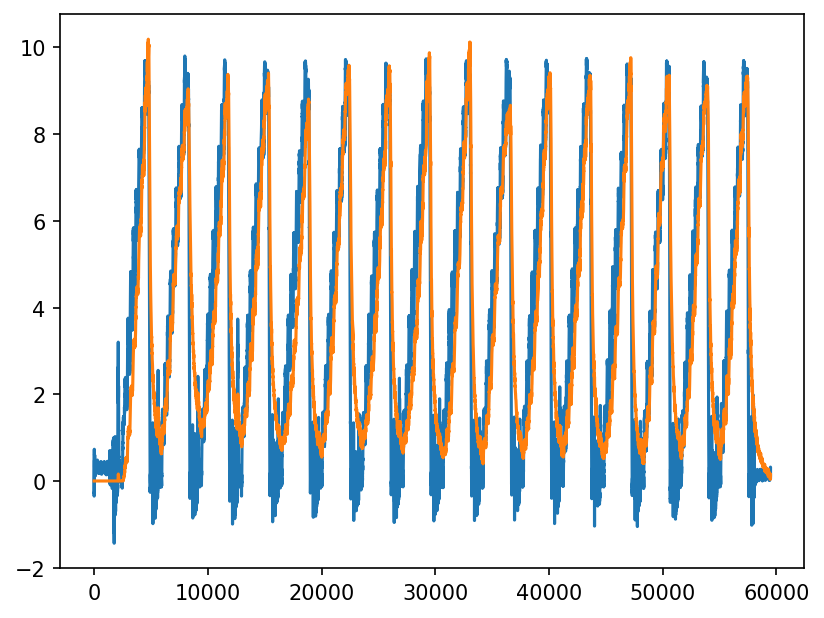

In [27]:

plt.plot(data['F_z'])

plt.plot(data['F_z0'])
# plt.plot(data['F_z4'])
# plt.plot(data['F_z3'])
# plt.plot(data['F_z12'])
# plt.plot(data['F_z15'])

# ys = [data[f'F_z{i}'] for i in range(ARRAY_SIZE_SUB)]
# plt.plot(np.sum(ys, axis=0))



plt.show()


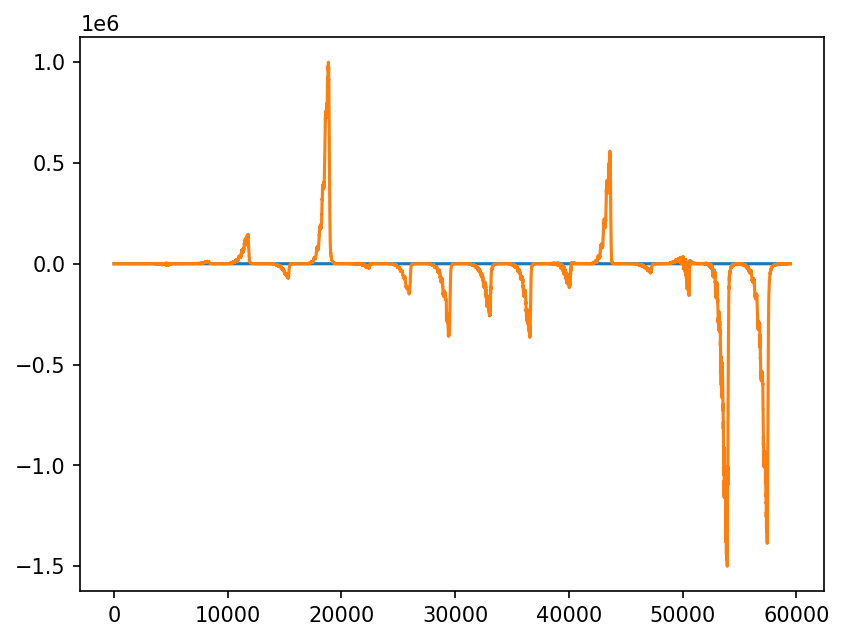

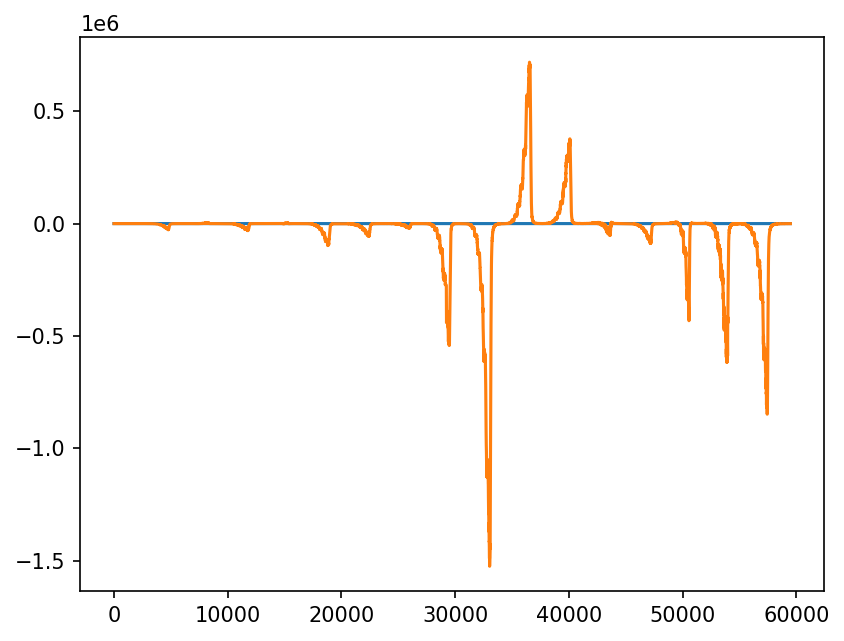

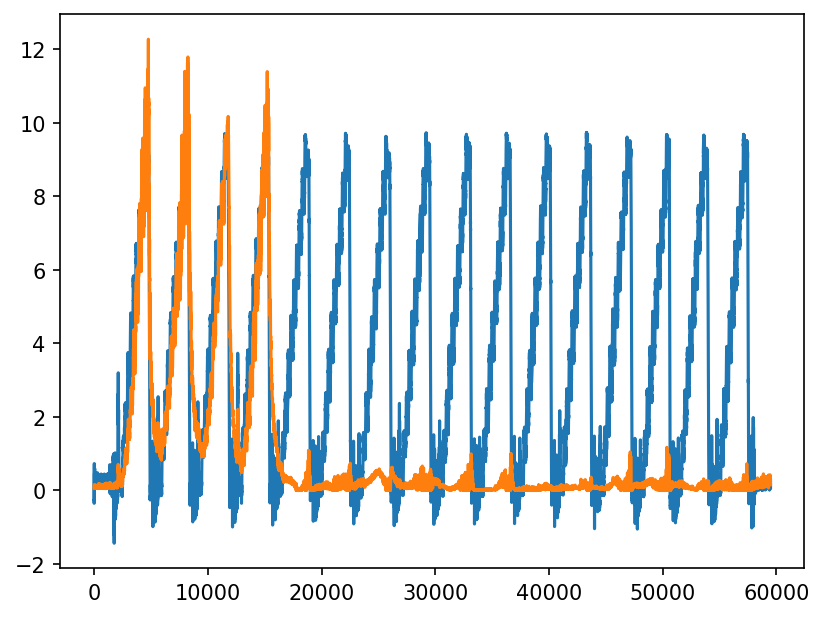

In [152]:
for letter in ['x', 'y', 'z']:
  plt.plot(data[f'F_{letter}'])
  plt.plot(data[f'F_{letter}0']+ data[f'F_{letter}1'] + data[f'F_{letter}2'] + data[f'F_{letter}3'])
  # plt.xlim(10000, 15000)
  # plt.ylim(-10,10)
  plt.show()
  
# plt.plot(data[f'Z0'])
# # plt.xlim(10000, 15000)
# plt.show()
  